## 2. PyTorch Implementation of Generative Adverarial Network (GAN) (50 points)

You are required to implement a simple Generative Adversarial Network (GAN) model and train it on the MNIST dataset. We have provided the main structure of the code in this Jupyter notebook, and you need to complete the code according to the comments.

In [104]:
# prerequisites
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Current device: {device}')

Current device: cuda


In [105]:
# Do not adjust any hyper parameter!
batch_size = 128
lr = 0.0001
z_dim = 100

In [106]:
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [107]:
# Do not modify the model architecture of `Generator`
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, g_output_dim)
    
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.tanh(self.fc4(x))
        
        return x


# Do not modify the model architecture of `Discriminator` 
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.sigmoid(self.fc4(x))
        
        return x

In [108]:
# build network
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim=z_dim, g_output_dim=mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

c:\Users\dianp\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [109]:
print(G)
print(D)

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)


In [110]:
# loss
loss_fn = nn.BCELoss() 

# optimizer
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [111]:
def D_train(x, G, D, mnist_dim, batch_size, z_dim, device):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(batch_size, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = loss_fn(D_output, y_real)

    # train discriminator on fake
    z = Variable(torch.randn(batch_size, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(batch_size, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = loss_fn(D_output, y_fake)

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item(), G, D


def G_train(G, D, batch_size, z_dim, device):
    #=======================Train the generator=======================#
    ################################################################################
    # TODO (30 points):                                                                        #
    G.zero_grad()
    z = Variable(torch.randn(batch_size, z_dim).to(device))
    x_fake, y_real = G(z), Variable(torch.ones(batch_size, 1).to(device))

    D_output = D(x_fake)
    G_loss = loss_fn(D_output, y_real)
    
    G_optimizer.zero_grad()
    G_loss.backward()
    G_optimizer.step()

    # finish the procedure of training the generator                               #
    ################################################################################
    return G_loss.data.item(),G,D

In [112]:
n_epoch = 100
epochs = []
D_losses_list, G_losses_list = np.array([],dtype=float),np.array([],dtype=float)
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_loss, G, D = D_train(x, G, D, mnist_dim, batch_size, z_dim, device)
        G_loss, G, D = G_train(G, D, batch_size, z_dim, device)
        D_losses.append(D_loss)
        G_losses.append(G_loss)
    D_loss_mean = torch.tensor(D_losses).mean().item()
    G_loss_mean = torch.tensor(G_losses).mean().item()
    print(D_loss_mean,G_loss_mean)
    
    print(
        f'[{epoch}/{n_epoch}]: '
        f'loss_d: {torch.tensor(D_losses).mean():.3f}, '
        f'loss_g: {torch.tensor(G_losses).mean():.3f}'
    )
    epochs.append(epoch)
    D_losses_list = np.append(D_losses_list,(round(D_loss_mean,3)))
    G_losses_list = np.append(G_losses_list,(round(G_loss_mean,3)))
    ## D_losses_list.np.append(round(D_loss_mean,3))
    ## G_losses_list.np.append(round(G_loss_mean,3))

0.9045330882072449 2.1999335289001465
[1/100]: loss_d: 0.905, loss_g: 2.200
1.0526297092437744 1.855867624282837
[2/100]: loss_d: 1.053, loss_g: 1.856
1.2869296073913574 1.4342527389526367
[3/100]: loss_d: 1.287, loss_g: 1.434
0.9962280988693237 1.899796485900879
[4/100]: loss_d: 0.996, loss_g: 1.900
0.9202588796615601 2.5027501583099365
[5/100]: loss_d: 0.920, loss_g: 2.503
0.9158613681793213 3.0458691120147705
[6/100]: loss_d: 0.916, loss_g: 3.046
0.5340707898139954 2.458268880844116
[7/100]: loss_d: 0.534, loss_g: 2.458
0.40765872597694397 3.3825573921203613
[8/100]: loss_d: 0.408, loss_g: 3.383
0.21352404356002808 4.084165096282959
[9/100]: loss_d: 0.214, loss_g: 4.084
0.4773257076740265 4.683924198150635
[10/100]: loss_d: 0.477, loss_g: 4.684
0.3674275875091553 4.076804161071777
[11/100]: loss_d: 0.367, loss_g: 4.077
0.3445817232131958 4.319217681884766
[12/100]: loss_d: 0.345, loss_g: 4.319
0.28298187255859375 4.536186218261719
[13/100]: loss_d: 0.283, loss_g: 4.536
0.33577001094

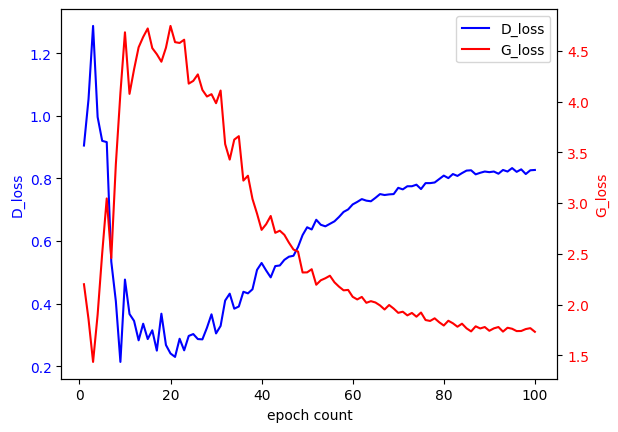

In [113]:
################################################################################
# TODO (10 points):                                                                        #
fig, ax1 = plt.subplots()

# 绘制第一个数据和设置标签
ax1.plot(epochs, D_losses_list, label='D_loss', color='b')
ax1.set_xlabel('epoch count')
ax1.set_ylabel('D_loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 创建第二个坐标轴并绘制数据
ax2 = ax1.twinx()
ax2.plot(epochs, G_losses_list, label='G_loss', color='r')
ax2.set_ylabel('G_loss', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# 添加图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper right')

# 显示图形
plt.show()
# you need to plot the training loss of generator and discriminator            #
# you may need to modify the training code to record the corresponding loss    #
################################################################################

In [114]:
print(D_losses_list)
print(G_losses_list)

[0.905 1.053 1.287 0.996 0.92  0.916 0.534 0.408 0.214 0.477 0.367 0.345
 0.283 0.336 0.287 0.315 0.25  0.368 0.268 0.241 0.23  0.288 0.251 0.297
 0.303 0.287 0.286 0.323 0.366 0.305 0.329 0.41  0.432 0.384 0.391 0.438
 0.433 0.446 0.508 0.53  0.506 0.484 0.52  0.522 0.54  0.55  0.553 0.581
 0.619 0.644 0.637 0.668 0.652 0.647 0.655 0.663 0.677 0.693 0.701 0.717
 0.725 0.734 0.729 0.727 0.738 0.75  0.747 0.749 0.75  0.77  0.765 0.775
 0.775 0.78  0.766 0.785 0.785 0.787 0.798 0.809 0.801 0.814 0.808 0.817
 0.825 0.826 0.813 0.818 0.822 0.82  0.822 0.815 0.827 0.822 0.833 0.821
 0.829 0.814 0.826 0.827]
[2.2   1.856 1.434 1.9   2.503 3.046 2.458 3.383 4.084 4.684 4.077 4.319
 4.536 4.638 4.722 4.528 4.468 4.394 4.532 4.747 4.587 4.579 4.611 4.178
 4.205 4.269 4.116 4.051 4.074 3.985 4.11  3.582 3.429 3.626 3.66  3.222
 3.27  3.041 2.896 2.736 2.792 2.873 2.707 2.728 2.687 2.61  2.542 2.522
 2.316 2.317 2.348 2.195 2.239 2.259 2.284 2.219 2.176 2.14  2.144 2.076
 2.05  2.075 2.017 2.033 

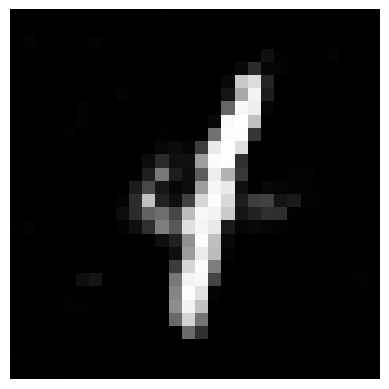

In [115]:
################################################################################
# TODO (10 points):                                                                        #

z = Variable(torch.randn(1, z_dim).to(device))
generated_image = G(z)

image_shape = (28, 28)

# 将一维数据恢复为二维图像
generated_image = generated_image.cpu().detach().numpy()
generated_image = generated_image.reshape(image_shape)

# 使用matplotlib显示图像
plt.imshow(generated_image, cmap='gray')
plt.axis('off')  # 隐藏坐标轴
plt.show()
# you need to generate an image with the trained generator                     #
# a sample result is given as follows                                      #
################################################################################